# Hugging face

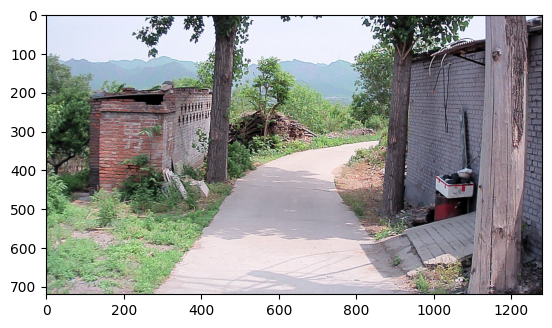

In [66]:
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, AutoModel

img_name = '1623170248079.png'
img = Image.open(f'/media/imlab/HDD/ORFD/training/image_data/{img_name}')
img_np = np.array(img)

plt.imshow(img_np)
plt.show()

img_size = 644
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-giant', crop_size={'height':img_size, 'width':img_size}, size={'height':img_size, 'width':img_size})
inputs = processor(images=img_np, return_tensors="pt")

# model = AutoModel.from_pretrained('facebook/dinov2-giant')
# outputs = model(**inputs)
# last_hidden_states = outputs.last_hidden_state

output_size = int(inputs.pixel_values[0].shape[1]/14)

# Github

In [67]:
import torch
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
if device=="cuda": torch.cuda.empty_cache()
print('학습을 진행하는 기기:',device)

dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
# dinov2_vitg14.eval().to(device)

True
학습을 진행하는 기기: cuda:0


Using cache found in /home/imlab/.cache/torch/hub/facebookresearch_dinov2_main


In [68]:
import cv2

img = cv2.imread('/media/imlab/HDD/ORFD/training/dense_depth/1623170248079.png')

# 깊이 맵의 값을 0-255 범위로 정규화
depth_map_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# 정규화된 깊이 맵을 컬러맵으로 변환
depth_colormap = cv2.applyColorMap(depth_map_normalized.astype(np.uint8), cv2.COLORMAP_JET)

depth_input = processor(images=depth_colormap, return_tensors="pt")

# cv2.imshow('', depth_colormap)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


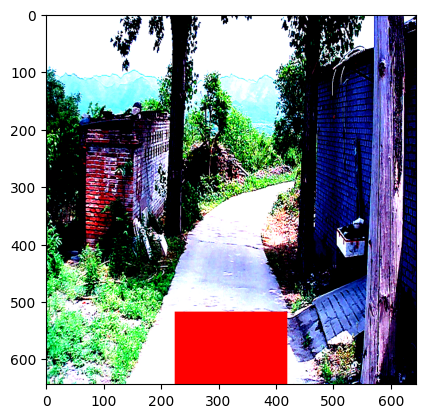

In [69]:
from numpy.linalg import norm

# model_input = torch.tensor(inputs.pixel_values).to(device)
model_input = inputs.pixel_values
model_output = dinov2_vitg14.get_intermediate_layers(model_input)[0][0].detach().numpy()

visualize=torch.permute(model_input[0], (1,2,0)).detach().numpy()
tmp_img = visualize.copy()

grid_size=14
box_size = img_size // grid_size  # num of grid per row and column
width_offset = 16

# 이미지 자르기
flatten_indices = []
for i in range(box_size):
    for j in range(box_size):
        left = j * grid_size
        upper = i * grid_size
        right = left + grid_size
        lower = upper + grid_size
        # box = visualize[upper:lower, left:right, :]
        # boxes.append(box)
        if (box_size-9<=i<=box_size-1)&(box_size-width_offset-1>=j>=width_offset):
            flatten_indices.append(i*box_size+j)
            tmp_img[upper:lower, left:right] = np.array((255, 0, 0))

plt.imshow(tmp_img)
plt.show()

mean = np.mean(model_output[flatten_indices], axis=0)
cosine_sim = np.dot(model_output, mean) / (norm(model_output)*norm(mean))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


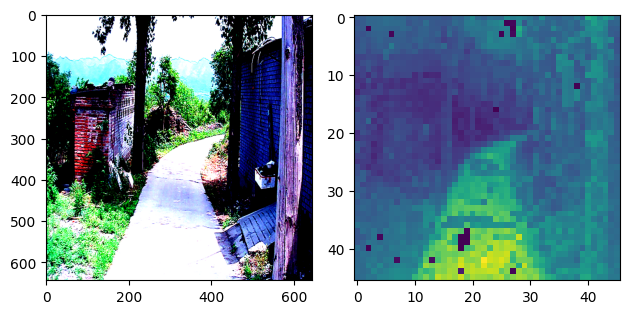

In [70]:
norm_cosine = cosine_sim/np.max(cosine_sim)

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine.reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


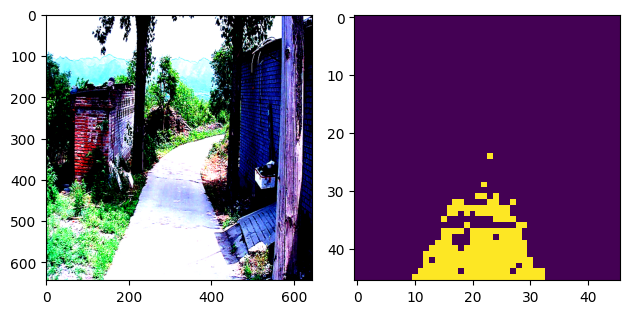

In [71]:
threshold_norm_cosine = norm_cosine.copy()

threshold = 0.65
non_drivable_indices = np.where(threshold_norm_cosine<threshold)[0]
drivable_indices = np.where(threshold_norm_cosine>=threshold)[0]
threshold_norm_cosine[non_drivable_indices] = 0
threshold_norm_cosine[drivable_indices] = 1

drivable_map = threshold_norm_cosine.reshape((output_size, output_size))

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(drivable_map)
# plt.colorbar()
plt.tight_layout()
plt.show()

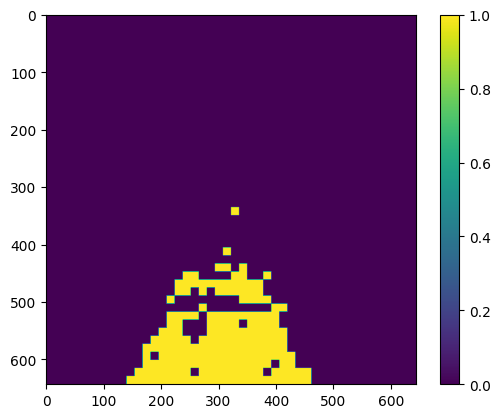

In [88]:
resized = cv2.resize(drivable_map, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
plt.imshow(resized)
plt.colorbar()
plt.show()

In [73]:
new_drivable = np.where(drivable_map==1)
new_row = new_drivable[0]
new_column = new_drivable[1]

flatten_indices2=[]
for i in new_row:
    for j in new_column:
        flatten_indices2.append(i*box_size+j)

mean2 = np.mean(model_output[flatten_indices2], axis=0)
cosine_sim2 = np.dot(model_output, mean2) / (norm(model_output)*norm(mean2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


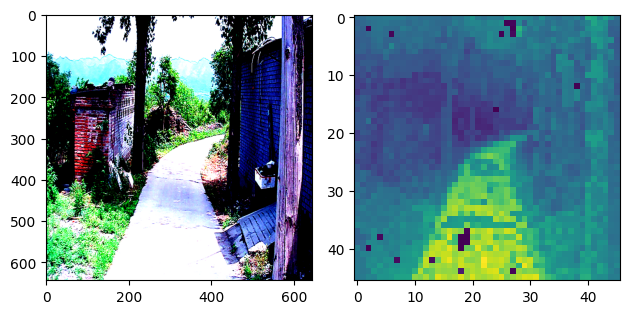

In [74]:
norm_cosine2 = cosine_sim2/np.max(cosine_sim2)

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine2.reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


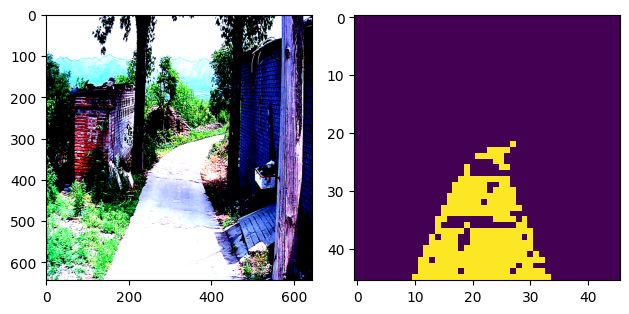

In [75]:
threshold_norm_cosine2 = norm_cosine2.copy()

threshold2 = 0.65
non_drivable_indices2 = np.where(threshold_norm_cosine2<threshold2)[0]
drivable_indices2 = np.where(threshold_norm_cosine2>=threshold2)[0]
threshold_norm_cosine2[non_drivable_indices2] = 0
threshold_norm_cosine2[drivable_indices2] = 1

drivable_map2 = threshold_norm_cosine2.reshape((output_size, output_size))

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(drivable_map2)
# plt.colorbar()
plt.tight_layout()
plt.show()

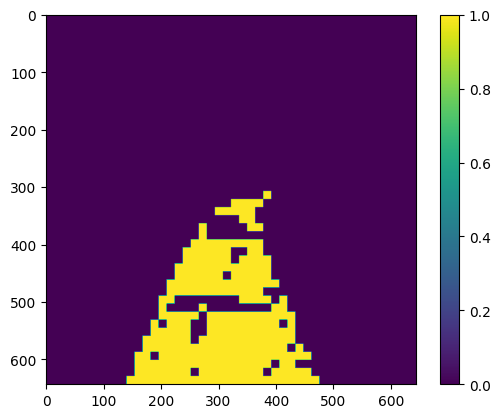

In [76]:
resized2 = cv2.resize(drivable_map2, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
plt.imshow(resized2)
plt.colorbar()
plt.show()

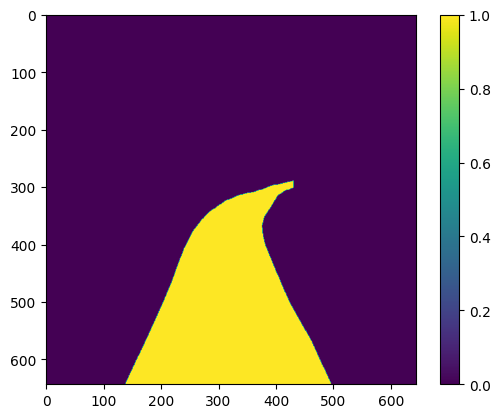

In [87]:
useDir = '/media/imlab/HDD/ORFD/training'

label_img_name = img_name.split('.')[0]+"_fillcolor.png"
label_dir = os.path.join(useDir, 'gt_image', label_img_name)
label_image = cv2.cvtColor(cv2.imread(label_dir), cv2.COLOR_BGR2RGB)
resized_label_image = cv2.resize(label_image, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

label = np.zeros((img_size, img_size), dtype=np.uint8)
label[resized_label_image[:,:,2] > 200] = 1

plt.imshow(label)
plt.colorbar()
plt.show()

In [97]:
def confusion_matrix(x, y, n, ignore_label=None, mask=None):
    if mask is None:
        mask = np.ones_like(x) == 1
    k = (x >= 0) & (y < n) & (x != ignore_label) & (mask.astype(np.bool_))
    return np.bincount(n * x[k].astype(int) + y[k], minlength=n**2).reshape(n, n)

def getScores(conf_matrix):
    if conf_matrix.sum() == 0:
        return 0, 0, 0, 0, 0
    with np.errstate(divide='ignore',invalid='ignore'):
        globalacc = np.diag(conf_matrix).sum() / np.float32(conf_matrix.sum())
        classpre = np.diag(conf_matrix) / conf_matrix.sum(0).astype(np.float32)
        classrecall = np.diag(conf_matrix) / conf_matrix.sum(1).astype(np.float32)
        IU = np.diag(conf_matrix) / (conf_matrix.sum(1) + conf_matrix.sum(0) - np.diag(conf_matrix)).astype(np.float32)
        pre = classpre[1]
        recall = classrecall[1]
        iou = IU[1]
        F_score = 2*(recall*pre)/(recall+pre)
    return globalacc, pre, recall, F_score, iou

num_labels = 2
conf_mat = np.zeros((num_labels, num_labels), dtype=np.float64)
conf_mat += confusion_matrix(np.int_(label), np.int_(resized2), num_labels)

globalacc, pre, recall, F_score, iou = getScores(conf_mat)
print ('glob acc : {0:.3f}, pre : {1:.3f}, recall : {2:.3f}, F_score : {3:.3f}, IoU : {4:.3f}'.format(globalacc, pre, recall, F_score, iou))

glob acc : 0.956, pre : 0.987, recall : 0.749, F_score : 0.852, IoU : 0.742
